In [22]:
import cv2 
import os
import time
import object_detection
import wget
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [1]:
model_name = 'powerline_model_hypertuned' 
backbone_model = 'ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8'

In [29]:
labels = [{'name':'Defective_Conductor', 'id':1}, {'name':'Defective_Insulator', 'id':2}, {'name':'Rusted', 'id':3}, {'name':'Insulator', 'id':4}]

with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

In [12]:
!python {files['<Path to TFgenerator Script>']} -x {os.path.join(paths['<train image path directory>')} -l {files['LABELMAP']} -o {os.path.join(paths['<path to annotated xml files>'], 'train.record')} 
!python {files['<Path to TFgenerator Script>']} -x {os.path.join(paths['<test image path directory>']} -l {files['LABELMAP']} -o {os.path.join(paths['<path to annotated xml files>'], 'test.record')} 

Successfully created the TFRecord file: Tensorflow\PowerProject\annotations\train.record
Successfully created the TFRecord file: Tensorflow\PowerProject\annotations\test.record


In [36]:
    !copy {os.path.join(paths['<Path to backbone model downloaded from model zoo>'], '<path to pipeline.config>')} {os.path.join(paths['<path to model_name>'])}

        1 file(s) copied.


In [30]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [31]:
config = config_util.get_configs_from_pipeline_file(files['<Path to pipeline.config>'])

In [32]:
config

{'model': ssd {
   num_classes: 4
   image_resizer {
     fixed_shape_resizer {
       height: 640
       width: 640
     }
   }
   feature_extractor {
     type: "ssd_mobilenet_v2_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 3.9999998989515007e-05
         }
       }
       initializer {
         random_normal_initializer {
           mean: 0.0
           stddev: 0.009999999776482582
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.996999979019165
         scale: true
         epsilon: 0.0010000000474974513
       }
     }
     use_depthwise: true
     override_base_feature_extractor_hyperparams: true
     fpn {
       min_level: 3
       max_level: 7
       additional_layer_depth: 128
     }
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 10.0
       x_scale: 10.0
       height_scale: 5.0
       width_scale: 5.0
     }
   }
   match

In [33]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [34]:
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['<path to backbone model folder>'], backbone_model, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['<path to train.record>')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['<path to test.record>')]

In [35]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['<path to model_name>'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

In [36]:
TRAINING_SCRIPT = os.path.join(paths['<Tensorflow model api path>'], 'research', 'object_detection', 'model_main_tf2.py')

In [37]:
train_command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=6000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])

In [38]:
print(train_command)

python Tensorflow\models\research\object_detection\model_main_tf2.py --model_dir=Tensorflow\PowerProject\models\powerline_model_hypertuned --pipeline_config_path=Tensorflow\PowerProject\models\powerline_model_hypertuned\pipeline.config --num_train_steps=6000


In [39]:
evaluation_command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])

In [40]:
print(evaluation_command)

python Tensorflow\models\research\object_detection\model_main_tf2.py --model_dir=Tensorflow\PowerProject\models\powerline_model_hypertuned --pipeline_config_path=Tensorflow\PowerProject\models\powerline_model_hypertuned\pipeline.config --checkpoint_dir=Tensorflow\PowerProject\models\powerline_model_hypertuned


In [41]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [42]:
configs = config_util.get_configs_from_pipeline_file(files['<path to pipeline.config file>'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['<path to model_name> 'ckpt-7')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

In [43]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [44]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [115]:
IMAGE_PATH = os.path.join(paths['<path to new image for detection>')

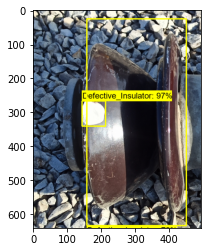

In [116]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=6,
            min_score_thresh=.6,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()